In [54]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('../../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
name = '../../../CLCosmo_Sim_database/data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
dat_open= dat[1].data

In [56]:
dat_open['cat1_id']

chararray(['10', '18', '24', ..., '97912', '37112', '74968'], dtype='<U11')

In [57]:
table = Table()
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']

In [58]:
import scipy
u = np.linspace(-100, 100, 2000)
pu = 0.5*(1 + scipy.special.erf(u))
def p_f(x):
    return np.interp(x, u, pu, left=None, right=None)

In [75]:
def lnLikelihood(p, table_cut, richness_min):
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = p
    params = np.log10(10**14.3), .5, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m 
    mu = rm_relation.proxy_mu_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    sigma= rm_relation.proxy_sigma_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    pdf_lnlambda = table_cut['richness']*rm_relation.pdf_richness_mass_relation(table_cut['richness'], np.log10(table_cut['M200c']), table_cut['redshift'], params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    if np.isnan(np.sum(np.log(pdf_lnlambda))): return -np.inf
    return np.sum(np.log(pdf_lnlambda))

In [76]:
initial = [3.33413625, -0.01682437,  2.34084305,  0.56353637, -0.10364501,  0.00758468,]

In [91]:
def params(table_cut, richness_min):
    from multiprocessing import Pool
    nwalker=20
    pos=.0001*np.random.randn(nwalker,6) + initial
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalker, 6, lnLikelihood, pool=pool,args=[table_cut, richness_min])
        sampler.run_mcmc(pos, 400, progress=True);
    flat_samples = sampler.get_chain(discard=10, thin=3, flat=True)
    p = np.mean(flat_samples[2000:], axis=0)
    p_err = np.std(flat_samples[2000:], axis=0)
    params = [np.log10(10**14.3), .5]
    params_err = [0,0]
    params = params + list(p)
    params_err = params_err + list(p_err)
    return params, params_err, flat_samples

In [92]:
#plt.plot(flat_samples2[:,2])
#print(np.mean(flat_samples2[2000:], axis=0))
#np.save('fiducial.pkl',flat_samples1[2000:],)

In [93]:
#plt.plot(flat_samples2[:,2])
#print(np.mean(flat_samples2[2000:], axis=0))
#np.save('fiducial.pkl',flat_samples1[2000:],)

In [94]:
#p = np.mean(flat_samples2[2000:], axis=0)
#params = [np.log10(10**14.3), .5]
#params = params + list(p)

In [95]:
table_cut1 = table[(table['M200c'] > 4e13)*(table['richness'] > 10)*(table['redshift'] < 1)*(table['redshift'] > .2)]

In [96]:
params1, params1_err, flat_samples1 = params(table_cut1, 10)

100%|██████████| 400/400 [00:07<00:00, 55.77it/s]


In [97]:
table_cut2 = table[(table['M200c'] > 1e13)*(table['richness'] > 5)*(table['redshift'] < 1)*(table['redshift'] > .2)]

In [98]:
params2, params2_err, flat_samples2 = params(table_cut2, 5)

100%|██████████| 400/400 [00:13<00:00, 28.58it/s]


In [99]:
table_cut3 = table[(table['M200c'] > 4e13)*(table['richness'] > 5)*(table['redshift'] < 1)*(table['redshift'] > .2)]
params3, params3_err, flat_samples3 = params(table_cut3, 5)

100%|██████████| 400/400 [00:09<00:00, 42.06it/s]


In [100]:
table_cut4 = table[(table['M200c'] > 4e13)*(table['richness'] > 20)*(table['redshift'] < 1)*(table['redshift'] > .2)]
params4, params4_err, flat_samples4 = params(table_cut4, 20)

100%|██████████| 400/400 [00:04<00:00, 89.88it/s] 


In [101]:
names = ['1', '2', '3', '4', '5', '6']
labels = [r'\ln \lambda_0', r'\mu_z', r'\mu_m', r'\sigma_{\ln \lambda, 0}', r'\sigma_z', r'\sigma_m']
settings={'mult_bias_correction_order':0,'smooth_scale_2D':4, 'smooth_scale_1D':4, 'boundary_correction_order':0}

In [109]:
from getdist import plots, MCSamples
%matplotlib inline
n_cut=18000
name='1-halo=nfw+c-M=Duffy08_rmin=1.0-rmax=3.5_photoz=Truez_hmf=Despali16'
which = 'WLxN'
t = np.load(f'../chains/{which}/MCMC_fit_m-r_{which}_{name}.pkl', allow_pickle = True)
WLxNRmax35 = MCSamples(samples=t['flat_chains'][n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='Baseline WLxN')
name='1-halo=nfw+c-M=Duffy08_rmin=1.0-rmax=3.5_photoz=Truez_hmf=Despali16'
which = 'MxN'
t = np.load(f'../chains/{which}/MCMC_fit_m-r_{which}_{name}.pkl', allow_pickle = True)
MxNRmax35 = MCSamples(samples=t['flat_chains'][n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='Baseline MxN')

Removed no burn in
Removed no burn in


In [110]:
n_cut = 2000
p1 = MCSamples(samples=flat_samples1[n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='(fiducial) $M > 4.10^{13}+\lambda > 10$')
p2 = MCSamples(samples=flat_samples2[n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='(full) $M > 10^{13}+\lambda > 5$')
p3 = MCSamples(samples=flat_samples3[n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='(low richness min) $M > 4.10^{13}+\lambda > 5$')
p4 = MCSamples(samples=flat_samples4[n_cut:],names = names, 
                    labels = labels, 
                     settings=settings, 
                     label='(high richness min) $M > 4.10^{13}+\lambda > 20$')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


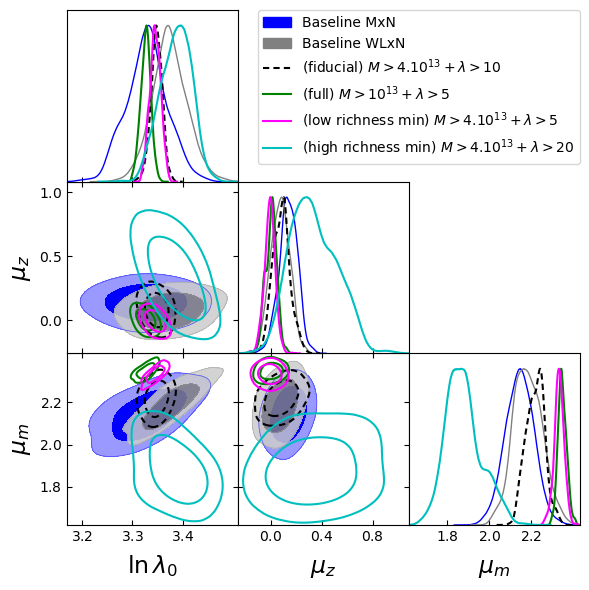

In [124]:
g = plots.get_subplot_plotter(subplot_size=2.)
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 13
marker_args = {'lw':0.75, 'markersize':0.75, 'ls':'--','color':'b'}
range_ = {'1':[2.5,4], '2':[-2,2], '3':[1,4], '4':[0.1,1.2],'5':[-1.5,1.5], '6':[-0.5,0.5], }
g.triangle_plot(
                [MxNRmax35, WLxNRmax35, p1, p2, p3, p4], 
                filled=[True, True, False, False, False, False, False], 
    
                contour_colors = ['blue','grey','k', 'g','magenta'], 
                contour_ls=['-','-','--', '-', '-'],
                contour_lws=[1,1,1.5,1.5,1.5,1.5],
                legend_fontsize = 10,
                params=['1','2','3',],
                fine_bins = 3,  )
plt.savefig(f'../fig/mcmc_scaling_relation_fiducial.png', dpi = 300)

In [32]:
for i in range(8):
    print(f'{params1[i]:.2f} $\pm$ {params1_err[i]:.2f}')

14.30 $\pm$ 0.00
0.50 $\pm$ 0.00
3.35 $\pm$ 0.01
0.06 $\pm$ 0.06
2.23 $\pm$ 0.04
0.56 $\pm$ 0.01
-0.04 $\pm$ 0.04
0.10 $\pm$ 0.02


In [23]:
for i in range(8):
    print(f'{params2[i]:.3f} $\pm$ {params2_err[i]:.2f}')

14.300 $\pm$ 0.00
0.500 $\pm$ 0.00
3.333 $\pm$ 0.01
0.015 $\pm$ 0.04
2.373 $\pm$ 0.02
0.548 $\pm$ 0.01
-0.137 $\pm$ 0.02
-0.048 $\pm$ 0.01


In [24]:
for i in range(8):
    print(f'{params3[i]:.3f} $\pm$ {params3_err[i]:.2f}')

14.300 $\pm$ 0.00
0.500 $\pm$ 0.00
3.345 $\pm$ 0.01
0.004 $\pm$ 0.04
2.338 $\pm$ 0.02
0.583 $\pm$ 0.01
-0.042 $\pm$ 0.03
0.102 $\pm$ 0.01
